# Classifiez automatiquement des biens de consommation - PLACE DE MARCHE
# Notebook 3 - Classification supervisée - IMAGE

# <a name="C0">SOMMAIRE</a>

## Travail préparatoire
### <a href="#C1">1. Set up Environnement</a>
### <a href="#C2">2. Travail sur le DF</a>
### <a href="#C3">3. Modèle supervisé sans data augmentation pré entrainé</a>
### <a href="#C4">4. Modèle supervisé avec data augmentation avec entrainement </a>
### <a href="#C5">5. Modèle supervisé sans data augmentation avec entrainement </a>





Les données
https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip

Notebook d'exemple pour la faisabilité : 
https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P6/Weather_Images_CNN_Transfer_Learning_Stage_1_feasibility_V1.0.ipynb



### Ce qu'il faut faire :


#### 1) Fonctions de prétraitement et explorations
Un ou des notebooks (ou des fichiers .py) contenant les fonctions permettant le prétraitement et la feature extraction des données textes et images ainsi que les résultats de l’étude de faisabilité (graphiques, mesure de similarité) 


#### 2) Un notebook de classification supervisée des images
Un notebook (ou code commenté au choix) d’essais des différentes approches de modélisation (non cleané, pour comprendre votre démarche).

#### 3)Un script Python (notebook ou fichier .py) de test de l’API et le fichier au format “csv” contenant les produits extraits
Un notebook de simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation.

#### 4) Présentation
Un support de présentation détaillant le travail réalisé



### Concernant la propriété intélectuelle =>  à mettre dans la présentation 
Mail de Linda, Lead Data Scientist
"PS : J’ai bien vérifié qu’il n’y avait aucune contrainte de propriété intellectuelle sur les données et les images."


# - - - - - - - TRAVAIL PREPARATOIRE - - - - - - - -

# <a name="C1">1. Set up environnement</a>
<a href="#C0">SOMMAIRE</a>

In [1]:
#Import des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import isnan
import scipy.stats
%matplotlib inline

#Réglages d'affichage
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_colwidth', 2000)

# Rappel du thème utilisé
sns.set_style('darkgrid')
sns.set_palette('Set2')


import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) 

Num GPUs Available:  0


In [2]:
#Import des données
flipkart_df = pd.read_csv('C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/flipkart_com-ecommerce_sample_1050.csv')

# <a name="C2">2. Travail sur le DF</a>
<a href="#C0">SOMMAIRE</a>

Home_Furnishing                 150
Baby_Care                       150
Watches                         150
Home_Decor_and_Festive_Needs    150
Kitchen_and_Dining              150
Beauty_and_Personal_Care        150
Computers                       150
Name: category, dtype: int64
Home_Furnishing


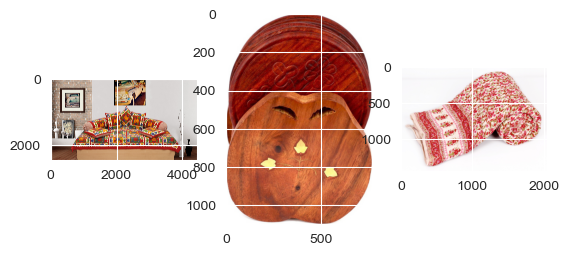

Baby_Care


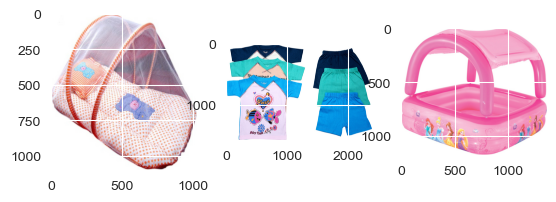

Watches


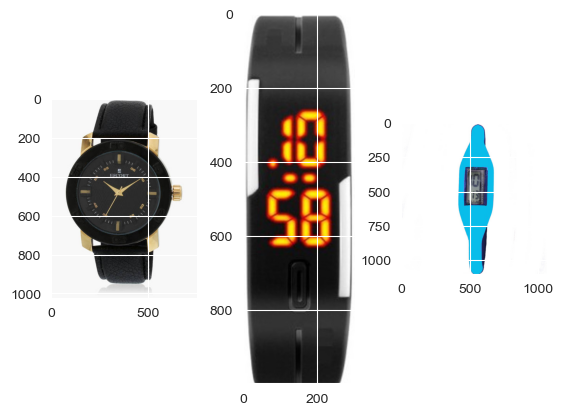

Home_Decor_and_Festive_Needs


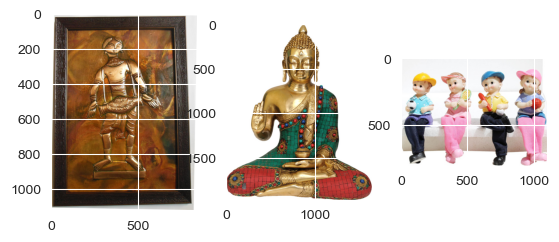

Kitchen_and_Dining


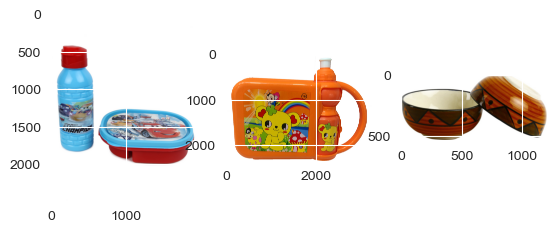

Beauty_and_Personal_Care


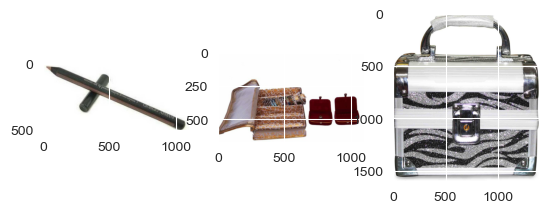

Computers


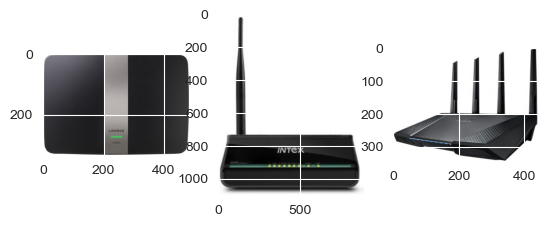

In [106]:
#création d'une copie pour pouvoir revenir au fichier initial si besoin
df=flipkart_df.copy()
df=df[['product_name','product_category_tree','image']]
#on isole la catégorie en créant une nouvelle variable
df['category']=(df.product_category_tree.str[2:-2].str.split(' >> ')).map(lambda x: x[0])
df.category.unique()
df.category = df.category.str.replace(' ', '_')
df.category = df.category.str.replace('&', 'and')
print(df['category'].value_counts())
df.drop('product_category_tree',axis=1,inplace=True)
path = "C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/"
df['image_path']=df.image.apply(lambda x : str(path+x))
from matplotlib.image import imread

list_labels = df.category.unique()
def list_fct(name) :
    list_image_name = [df["image_path"][i] for i in range(len(df)) if df["category"][i]==name]
    return list_image_name

for label in list_labels :
    list_label=[df["image_path"][i] for i in range(len(df)) if df["category"][i]==label]
    globals()[f'list_{label}'] = list_label
    print(label)
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = list_fct(label)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

# <a name="C3">3. Modèle supervisé sans data augmentation pré entrainé</a>
<a href="#C0">SOMMAIRE</a>

In [4]:
#modele pré entrainé
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

#création features des images
images_features = []
i=0 
for image_file in df["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000


(1050, 4096)

In [5]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score as ARI
import time

temps1 = time.time()

#on entraine un TSNE sur le feat_pca
tsne = TSNE(n_components=2,init='random')
T = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

(1050, 4096)
(1050, 803)
temps de T-SNE :             5.05 secondes


In [6]:
# X et y
X=T
y=df.category

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Création et ajustement du modèle k-plus proches voisins
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Prédiction des étiquettes sur l'ensemble de test
test_labels = knn.predict(X_test)

# Évaluation de la performance du modèle
accuracy = accuracy_score(y_test, test_labels)
print("Exactitude : ", accuracy)

# Affichage d'un rapport de classification détaillé
print(classification_report(y_test, test_labels))

Exactitude :  0.8031746031746032
                              precision    recall  f1-score   support

                   Baby_Care       0.60      0.78      0.68        45
    Beauty_and_Personal_Care       0.82      0.78      0.80        36
                   Computers       0.75      0.92      0.83        52
Home_Decor_and_Festive_Needs       0.82      0.73      0.77        44
             Home_Furnishing       0.81      0.67      0.74        52
          Kitchen_and_Dining       0.97      0.79      0.87        38
                     Watches       0.98      0.94      0.96        48

                    accuracy                           0.80       315
                   macro avg       0.82      0.80      0.81       315
                weighted avg       0.82      0.80      0.81       315



L'indice de Rand est de 0.60449.


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


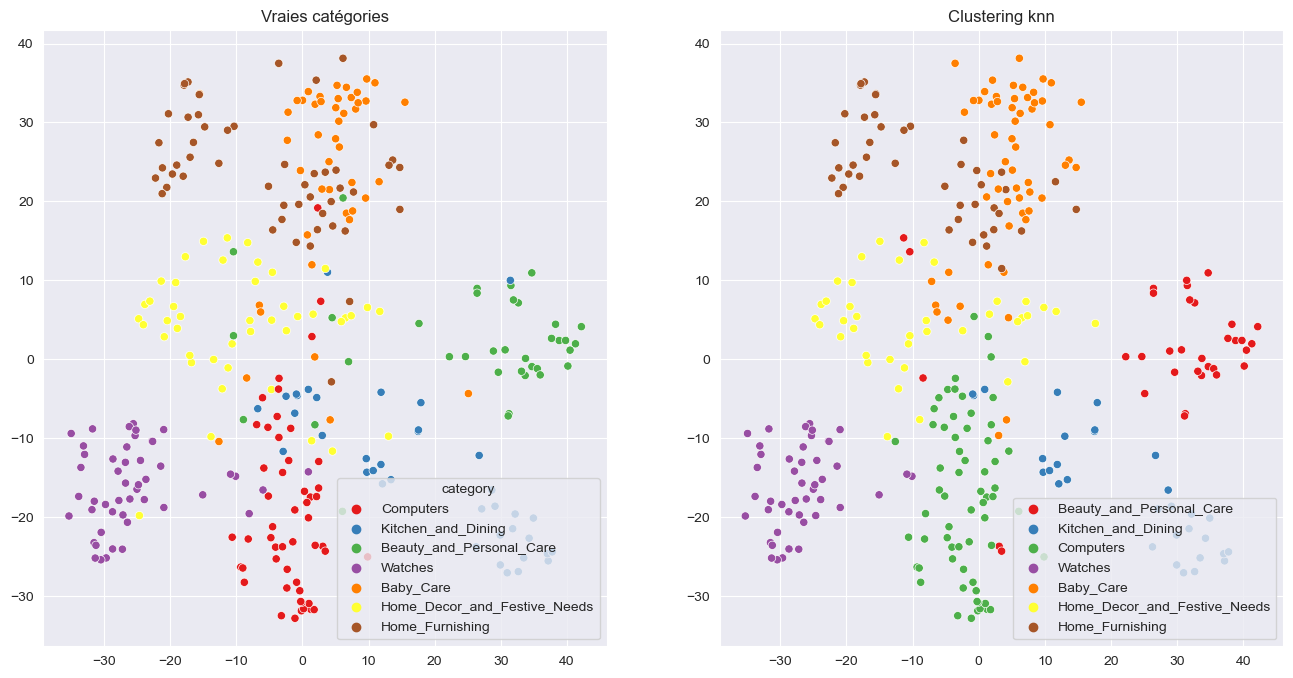

In [8]:
#score pour comparaison
indice_rand=ARI(y_test, test_labels)
print("L'indice de Rand est de {}.".format(round(indice_rand,5)))

#on prépare les deux graphiques 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))
    
#on affiche le TSNE avec les vrais étiquettes
ax1.set_title('Vraies catégories')
sns.scatterplot(X_test[:,0], X_test[:,1],hue=y_test, palette="Set1", ax=ax1)
    
#on affiche le TSNE avec les étiquettes prédites
ax2.set_title('Clustering knn')
sns.scatterplot(X_test[:,0], X_test[:,1],hue=test_labels, palette="Set1", ax=ax2)
plt.show()
    

# <a name="C4">4. Modèle supervisé avec data augmentation avec entrainement </a>
<a href="#C0">SOMMAIRE</a>
https://becominghuman.ai/using-keras-imagedatagenerator-with-transfer-learning-c4787d430060

In [11]:
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import numpy as np

In [13]:
train_df

,product_name,image,category,image_path
108,Rama Floral Single Quilts & Comforters Blue-Beige,5aacf8f5154afea2ac22fc767d072677.jpg,Home_Furnishing,C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/5aacf8f5154afea2ac22fc767d072677.jpg
388,Anna Andre Paris Set of Dark Fire & Numero 1 Deodorants Combo Set,98ad5b99ad96695568d8f143b11ab740.jpg,Beauty_and_Personal_Care,C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/98ad5b99ad96695568d8f143b11ab740.jpg
106,Bestway 1.47m x 1.47m x 1.22m/Play With Sun Shade Inflatable Play Pool,184ecf07ca4e2872eaf53d2344a1e783.jpg,Baby_Care,C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/184ecf07ca4e2872eaf53d2344a1e783.jpg
665,Welhouse Cotton Hand & Face Towel Set,d6a50203fad654981605a70a7bde52b7.jpg,Baby_Care,C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/d6a50203fad654981605a70a7bde52b7.jpg
821,Raymond Abstract Single Blanket Brown,ca82e1f23bb6cac66a32fce1c22534a3.jpg,Home_Furnishing,C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/ca82e1f23bb6cac66a32fce1c22534a3.jpg
276,Pittsburgh Polo Club PBPC-505-GRN Analog Watch - For Men,14826adf9bc4c34ea566dae3d85ef7cf.jpg,Watches,C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/14826adf9bc4c34ea566dae3d85ef7cf.jpg
547,Maxima 01727LPLN Mac Gold Analog Watch - For Women,987e13b445c34bfedb9796d2bb78d593.jpg,Watches,C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/987e13b445c34bfedb9796d2bb78d593.jpg
987,Hand Art Terracotta Mask Showpiece - 28 cm,42770faa04bfcf2b62e7ef335e1b1965.jpg,Home_Decor_and_Festive_Needs,C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/42770faa04bfcf2b62e7ef335e1b1965.jpg
321,Apple MD199HN/A,5df72b5295dc5e6126693e640b50f3a2.jpg,Computers,C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/5df72b5295dc5e6126693e640b50f3a2.jpg
327,Edimax BR-6428NC,f3ad282dac6ef0e30585a49ac67a322b.jpg,Computers,C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/f3ad282dac6ef0e30585a49ac67a322b.jpg


In [39]:
#séparation train et validation
train_df, val_test_df = train_test_split(df, test_size=0.3, stratify=df['category'])
test_df, validation_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['category'])

#datagen
train_datagen = ImageDataGenerator(rescale = 1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255)

#generator

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='image_path',
    y_col='category',
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_dataframe(
    dataframe=validation_df,
    directory=None,
    x_col='image_path',
    y_col='category',
    target_size=(224, 224),
    batch_size=10,
    class_mode='categorical'
)

Found 735 validated image filenames belonging to 7 classes.
Found 158 validated image filenames belonging to 7 classes.


In [40]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

vgg_model = VGG16(include_top=False, input_shape=(224, 224, 3))

for layer in vgg_model.layers:
    layer.trainable=False

flat1 = Flatten()(vgg_model.layers[-1].output)
class1 = Dense(256, activation='relu')(flat1)
output = Dense(7, activation='softmax')(class1)

model_aumgm = Model(inputs = vgg_model.inputs, outputs = output)

In [41]:
model_aumgm.summary()
model_aumgm.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_augm = model_aumgm.fit(train_generator,
                    validation_data = validation_generator,
                    epochs=10, verbose=1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


74/74 [==============================] - 95s 1s/step - loss: 2.1688 - accuracy: 0.4857 - val_loss: 1.6823 - val_accuracy: 0.4937
Epoch 2/10
74/74 [==============================] - 93s 1s/step - loss: 0.9253 - accuracy: 0.6762 - val_loss: 1.0626 - val_accuracy: 0.6519
Epoch 3/10
74/74 [==============================] - 92s 1s/step - loss: 0.8599 - accuracy: 0.7061 - val_loss: 1.1483 - val_accuracy: 0.6709
Epoch 4/10
74/74 [==============================] - 93s 1s/step - loss: 0.7811 - accuracy: 0.7497 - val_loss: 1.0879 - val_accuracy: 0.7468
Epoch 5/10
74/74 [==============================] - 94s 1s/step - loss: 0.8627 - accuracy: 0.7238 - val_loss: 1.1599 - val_accuracy: 0.6709
Epoch 6/10
74/74 [==============================] - 95s 1s/step - loss: 0.6169 - accuracy: 0.7932 - val_loss: 1.2692 - val_accuracy: 0.6899
Epoch 7/10
74/74 [==============================] - 94s 1s/step - loss: 0.5879 - accuracy: 0.7905 - val_loss: 0.8609 - val_accuracy: 0.8038
Epoch 8/10
74/74 [=============

In [43]:
model_aumgm.save("VGG_image_classif_augm.h5")
print("Saved model to disk")

Saved model to disk


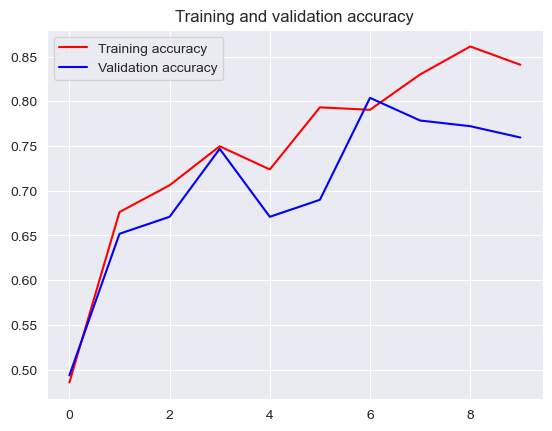

<Figure size 640x480 with 0 Axes>

In [46]:
acc = history_augm.history['accuracy']
val_acc = history_augm.history['val_accuracy']
loss = history_augm.history['loss']
val_loss = history_augm.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [55]:
#création prédictions
y_pred_dataaum = []
i=0 
for image_file in test_df["image_path"] :
    if i%30 == 0 : print(i,'/',(len(test_df.image_path)))
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    y_pred_dataaum.append(model_aumgm.predict(image, verbose=0)[0])

y_pred_dataaum = np.asarray(y_pred_dataaum)
y_pred_dataaum.shape

0 / 157
30 / 157
60 / 157
90 / 157
120 / 157
150 / 157


(157, 7)

In [71]:
pred_data_augm=np.argmax(y_pred_dataaum,axis=1)
inverse_class_indices = {v: k for k, v in validation_generator.class_indices.items()}
y_pred_labels = [inverse_class_indices[label] for label in pred_data_augm]
y_true = test_df.category

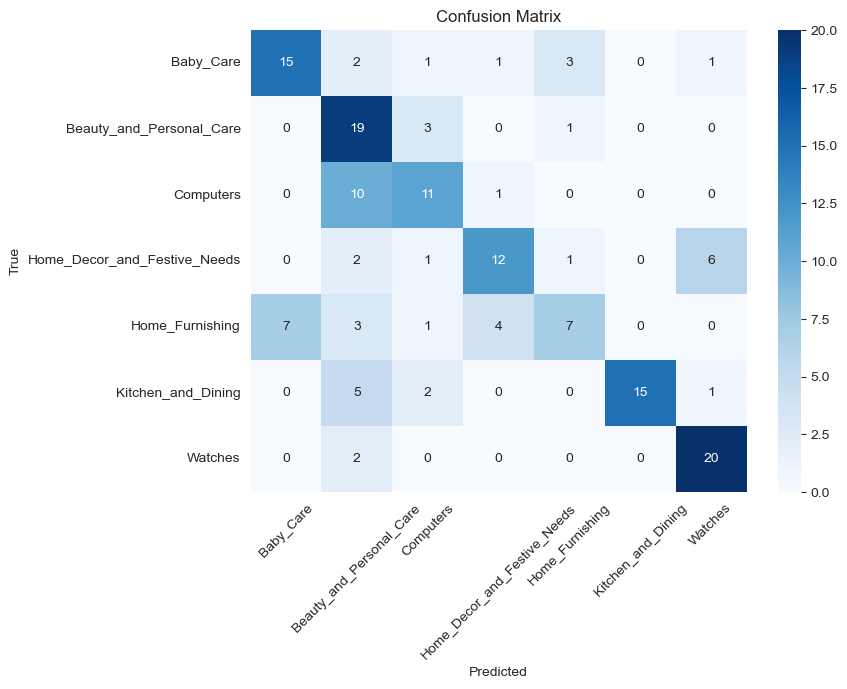

In [70]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_true, y_pred_labels)
class_labels = list(validation_generator.class_indices.keys())
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
ax.set_title('Confusion Matrix')
plt.show()


In [72]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true, y_pred_labels, target_names=class_labels)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
                              precision    recall  f1-score   support

                   Baby_Care       0.68      0.65      0.67        23
    Beauty_and_Personal_Care       0.44      0.83      0.58        23
                   Computers       0.58      0.50      0.54        22
Home_Decor_and_Festive_Needs       0.67      0.55      0.60        22
             Home_Furnishing       0.58      0.32      0.41        22
          Kitchen_and_Dining       1.00      0.65      0.79        23
                     Watches       0.71      0.91      0.80        22

                    accuracy                           0.63       157
                   macro avg       0.67      0.63      0.63       157
                weighted avg       0.67      0.63      0.63       157



In [111]:
import pandas as pd

dfs = []
for pred, true, img_path in zip(y_pred_labels, y_true, test_df.image_path):
    equal = pred == true
    dfone = pd.DataFrame({'y_pred_labels': [pred],
                       'y_true': [true],
                       'Equal': [equal],
                       'image_path': [img_path]})
    dfs.append(dfone)
result_df = pd.concat(dfs, ignore_index=True)
result_df

,y_pred_labels,y_true,Equal,image_path
0,Watches,Kitchen_and_Dining,False,C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/5a7a1287fef0d986a5e237797beee286.jpg
1,Baby_Care,Baby_Care,True,C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/d627a270302d23eef773d05ad01fd03c.jpg
2,Beauty_and_Personal_Care,Kitchen_and_Dining,False,C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/2971287a1ac427bd98c4778112d20d06.jpg
3,Home_Furnishing,Baby_Care,False,C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/87f256eeace1a0c2b1f934f061646da5.jpg
4,Kitchen_and_Dining,Kitchen_and_Dining,True,C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/02127f52e96fb72c66bf081d25104ef8.jpg
5,Kitchen_and_Dining,Kitchen_and_Dining,True,C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/3830dda3491cd5b28ed42ae544bc44f0.jpg
6,Baby_Care,Baby_Care,True,C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/3bc98543c7dd0d8fce5b8185b4a58c43.jpg
7,Watches,Watches,True,C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/b4e829e38d69d299a923abf8d11ac18d.jpg
8,Beauty_and_Personal_Care,Computers,False,C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/28e3f1e490cfc4b47bfb50671ff93283.jpg
9,Beauty_and_Personal_Care,Baby_Care,False,C:/Users/Me/Documents/1- DATA SCIENCE/Projet 6/source/Images/70461caa9038cfa34d109ea056d57f5a.jpg


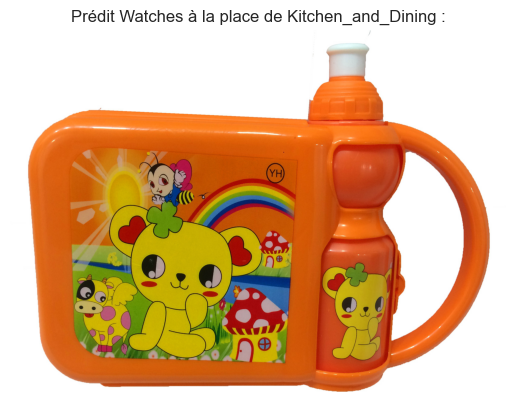

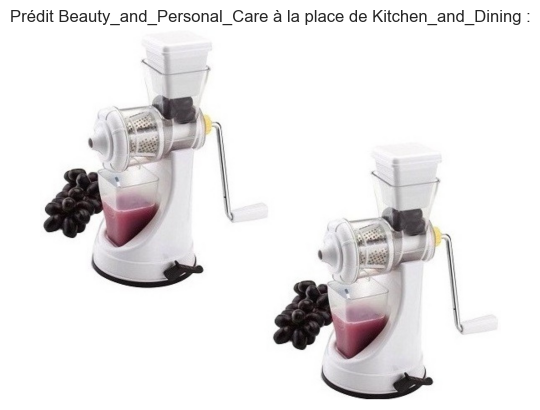

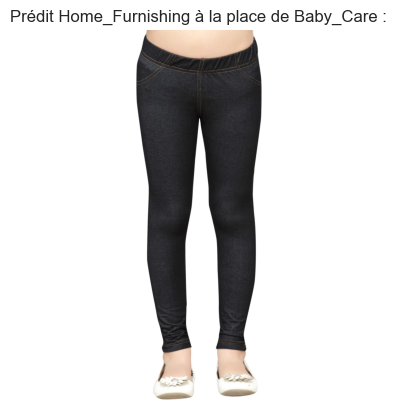

In [112]:
false_predict=result_df[result_df.Equal==False]
for i in range(3) :
    row_false=false_predict.iloc[i]
    image = plt.imread(row_false[3])
    plt.imshow(image)
    plt.title(f"Prédit {row_false[0]} à la place de {row_false[1]} :")
    plt.axis('off')
    plt.show()

# <a name="C5">5. Modèle supervisé sans data augmentation avec entrainement </a>
<a href="#C0">SOMMAIRE</a>
https://becominghuman.ai/using-keras-imagedatagenerator-with-transfer-learning-c4787d430060

In [116]:
#preprocessing train images
image_size = (224, 224)
image_paths = train_df['image_path'].values
images = []
for i, image_path in enumerate(image_paths):
    img = load_img(image_path, target_size=image_size)
    img_array = np.array(img)
    img_array = preprocess_input(img_array)
    images.append(img_array)
    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1} images out of {len(image_paths)}")
train_data = np.array(images)

Processed 100 images out of 735
Processed 200 images out of 735
Processed 300 images out of 735
Processed 400 images out of 735
Processed 500 images out of 735


C:\ProgramData\Anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Processed 600 images out of 735
Processed 700 images out of 735


In [117]:
#preprocessing validation images
image_size = (224, 224)
image_paths = validation_df['image_path'].values
images = []
for i, image_path in enumerate(image_paths):
    img = load_img(image_path, target_size=image_size)
    img_array = np.array(img)
    img_array = preprocess_input(img_array)
    images.append(img_array)
    if (i + 1) % 100 == 0:
        print(f"Processed {i + 1} images out of {len(image_paths)}")
validation_data = np.array(images)

Processed 100 images out of 158


In [120]:
#encodage des labels 
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

all_labels = np.concatenate((train_df['category'], validation_df['category']))

#paramétrage
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_labels)
num_classes = len(label_encoder.classes_)
print('Nombre de catégories : '+str(num_classes))
train_encoded_labels = encoded_labels[:len(train_df)]
validation_encoded_labels = encoded_labels[len(train_df):]
train_one_hot_labels = to_categorical(train_encoded_labels, num_classes=num_classes)
validation_one_hot_labels = to_categorical(validation_encoded_labels, num_classes=num_classes)

Nombre de catégories : 7


In [121]:
model_sans_augm = Model(inputs = vgg_model.inputs, outputs = output)
model_sans_augm.summary()
model_sans_augm.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_sans_augm = model_sans_augm.fit(train_data, train_one_hot_labels,
                                        validation_data=(validation_data, validation_one_hot_labels),
                                        epochs=10, verbose=1)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [123]:
model_sans_augm.save("VGG_image_classif_sans_augm.h5")
print("Saved model to disk")

Saved model to disk


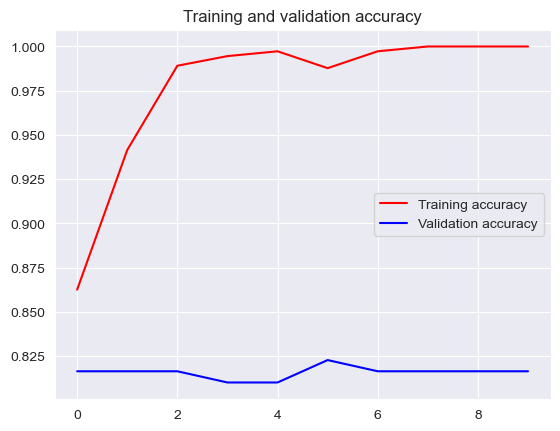

<Figure size 640x480 with 0 Axes>

In [124]:
acc = history_sans_augm.history['accuracy']
val_acc = history_sans_augm.history['val_accuracy']
loss = history_sans_augm.history['loss']
val_loss = history_sans_augm.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [125]:
#création prédictions
y_pred_data_sans_aum = []
i=0 
for image_file in test_df["image_path"] :
    if i%30 == 0 : print(i,'/',(len(test_df.image_path)))
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    y_pred_data_sans_aum.append(model_sans_augm.predict(image, verbose=0)[0])

y_pred_data_sans_aum = np.asarray(y_pred_data_sans_aum)
y_pred_data_sans_aum.shape

0 / 157
30 / 157
60 / 157
90 / 157
120 / 157
150 / 157


(157, 7)

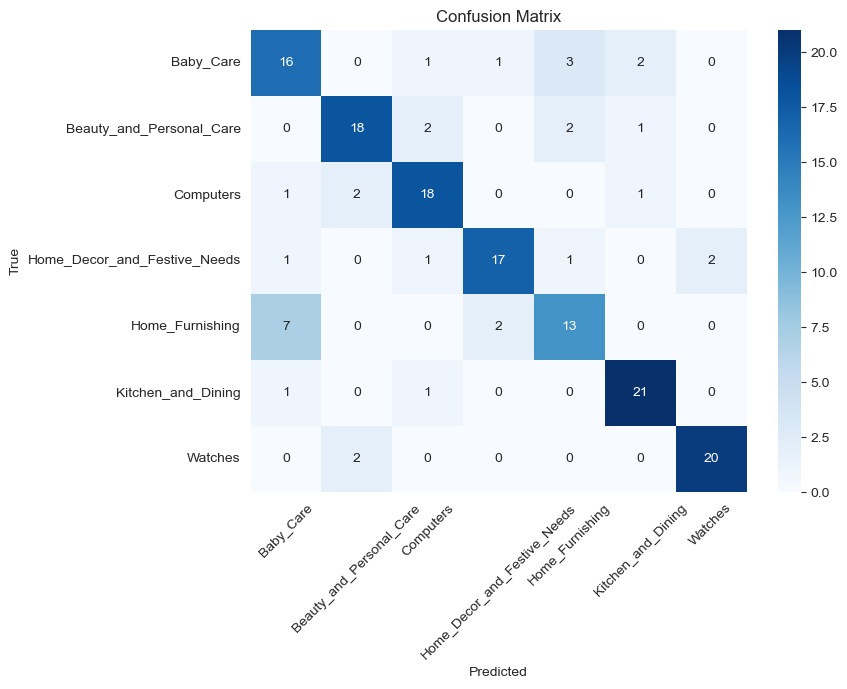

Classification Report:
                              precision    recall  f1-score   support

                   Baby_Care       0.62      0.70      0.65        23
    Beauty_and_Personal_Care       0.82      0.78      0.80        23
                   Computers       0.78      0.82      0.80        22
Home_Decor_and_Festive_Needs       0.85      0.77      0.81        22
             Home_Furnishing       0.68      0.59      0.63        22
          Kitchen_and_Dining       0.84      0.91      0.87        23
                     Watches       0.91      0.91      0.91        22

                    accuracy                           0.78       157
                   macro avg       0.79      0.78      0.78       157
                weighted avg       0.79      0.78      0.78       157



In [126]:
pred_data_sans_augm=np.argmax(y_pred_data_sans_aum,axis=1)
y_pred_labels_sans = label_encoder.inverse_transform(pred_data_sans_augm)
y_true = test_df.category


from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_true, y_pred_labels_sans)
class_labels = list(label_encoder.classes_)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_xticklabels(class_labels)
ax.set_yticklabels(class_labels)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
ax.set_title('Confusion Matrix')
plt.show()



from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_true, y_pred_labels_sans, target_names=class_labels)

# Print the classification report
print("Classification Report:")
print(report)

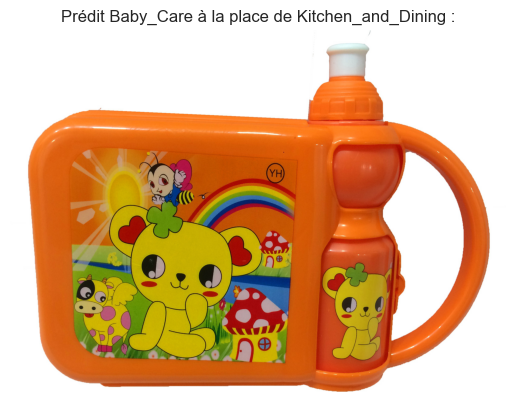

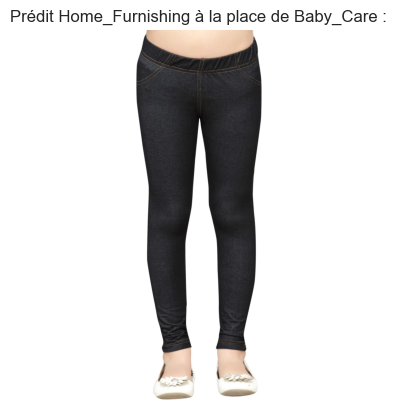

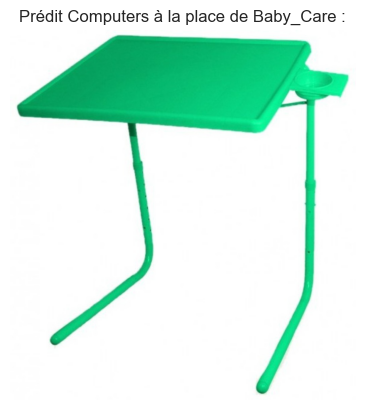

In [127]:
dfs = []
for pred, true, img_path in zip(y_pred_labels_sans, y_true, test_df.image_path):
    equal = pred == true
    dfone = pd.DataFrame({'y_pred_labels': [pred],
                       'y_true': [true],
                       'Equal': [equal],
                       'image_path': [img_path]})
    dfs.append(dfone)
result_df = pd.concat(dfs, ignore_index=True)
result_df

false_predict=result_df[result_df.Equal==False]
for i in range(3) :
    row_false=false_predict.iloc[i]
    image = plt.imread(row_false[3])
    plt.imshow(image)
    plt.title(f"Prédit {row_false[0]} à la place de {row_false[1]} :")
    plt.axis('off')
    plt.show()